In [2]:
from copy import deepcopy
from pathlib import Path
import pickle
import json
from typing import Literal

from gears import PertData
import seaborn as sns
from sklearn.linear_model import ElasticNet
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

/home/users/geroldcsendes/miniconda3/envs/scgpt_yml/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
with open("gene_name_map.json") as f:
    GENE_NAME_MAP = json.load(f)

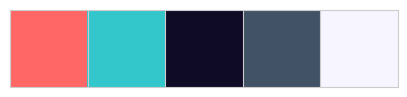

In [4]:
sns.set_style("whitegrid")
colors = ['#FF6666', '#33C7CC', '#0F0A26', '#425266', '#F7F5FF']
sns.set_palette(sns.color_palette(colors))
sns.palplot(sns.color_palette(colors))

In [5]:
def _filt_self_from_de(pert_data, is_norman: bool):

    DE_COL = "rank_genes_groups_cov_all"  # top_non_dropout_de_20

    gene_name_to_ensg = dict(zip(pert_data.adata.var["gene_name"], pert_data.adata.var.index))
    rank_genes_groups_cov_all = deepcopy(pert_data.adata.uns[DE_COL])

    updated_rank_genes_groups_cov_all = {}

    for k, v in rank_genes_groups_cov_all.items():
        condition = k.split("_")[1]
        condition_gene_name = condition.replace("ctrl+", "").replace("+ctrl", "")

        if is_norman:
            condition_ensg_name = gene_name_to_ensg.get(condition_gene_name, None)
            updated_rank_genes_groups_cov_all[k] = v[v != condition_ensg_name]
        else:
            if "+" in condition_gene_name:
                condition_gene_name = condition_gene_name.split("+")
                assert len(condition_gene_name) == 2
                condition_ensg_name = [gene_name_to_ensg.get(g, None) for g in condition_gene_name]
                mask = ~np.isin(v, condition_ensg_name)
                updated_rank_genes_groups_cov_all[k] = v[mask]
            else:
                condition_ensg_name = gene_name_to_ensg.get(condition_gene_name, None)
                updated_rank_genes_groups_cov_all[k] = v[v != condition_ensg_name]
    
    return updated_rank_genes_groups_cov_all


def eval(
        pred: np.ndarray, data: dict, pert_data: PertData, is_norman: bool, key_pattern: str,
        test: bool = True):

    col = 'test_y' if test else 'val_y'

    DE_COL = "rank_genes_groups_cov_all"  # top_non_dropout_de_20
    de_dict =  pert_data.adata.uns[DE_COL]
    de_dict_noself = _filt_self_from_de(pert_data, is_norman)

    ctrl = data['ctrl_mean']
    assert pred.shape[1] == ctrl.shape[0]

    cols = data[col].columns

    pearson_raw = []
    pearson_delta = []
    pearson_delta_de = []
    pearson_delta_de_no_knockout = []

    for i in range(pred.shape[0]):
        _pred = pred[i]
        _target_df = data[col].iloc[i]
        _target = data[col].iloc[i].values

        pearson_raw.append(pearsonr(_pred, _target)[0])
        pearson_delta.append(pearsonr(_pred - ctrl, _target - ctrl)[0])

        de = de_dict[key_pattern % _target_df.name][:20]
        de_pred_indices = np.array([idx for idx, i in enumerate(cols) if i in de])

        de_no_self = de_dict_noself[key_pattern % _target_df.name][:20]
        de_no_self_pred_indices = [idx for idx, i in enumerate(cols) if i in de_no_self]

        pearson_delta_de.append(
            pearsonr((_pred - ctrl)[de_pred_indices], (_target - ctrl)[de_pred_indices])[0]
        )
        pearson_delta_de_no_knockout.append(
            pearsonr((_pred - ctrl)[de_no_self_pred_indices], (_target - ctrl)[de_no_self_pred_indices])[0]
        )

    return dict(
        pearson=np.mean(pearson_raw),
        pearson_delta=np.mean(pearson_delta),
        pearson_de_delta=np.mean(pearson_delta_de),
        pearson_delta_de_no_knockout=np.mean(pearson_delta_de_no_knockout))

In [6]:
def _get_go_features(is_norman: bool, perturbation_list: list, go_pca: pd.DataFrame):

    GO_NULL_STR = "NULL"
    go_pca = go_pca.copy()
    pert_list = [i.replace("ctrl+", "").replace("+ctrl", "") for i in perturbation_list]
    if is_norman:
        # insert NULL as a row to the go_pca with 0 values
        go_pca.loc[GO_NULL_STR] = 0

        pert1 = []
        pert2 = []
        for i in pert_list:
            if '+' in i:
                p1, p2 = i.split('+')
                pert1.append(p1)
                pert2.append(p2)
            else:
                pert1.append(i)
                pert2.append('NULL')
        
        go_features = go_pca.loc[pert1].values + go_pca.loc[pert2].values

    else:

        go_features = go_pca.loc[pert_list]
    return go_features

def create_bulk_data(
    pert_data: PertData, go_pca_: pd.DataFrame, is_norman: bool):

    data_splits = deepcopy(pert_data.set2conditions)

    train_samples = data_splits['train']
    val_samples = data_splits['val']
    
    train_samples.remove('ctrl')
    if 'ctrl' in val_samples:
        val_samples.remove('ctrl')
    
    test_samples = data_splits['test']

    assert 'ctrl' not in test_samples, "ctrl in test samples"

    data = pert_data.adata.to_df()
    data['condition'] = pert_data.adata.obs['condition']
    data = data.groupby('condition').mean()

    train_x = _get_go_features(is_norman, train_samples, go_pca_)
    train_y = data.loc[train_samples].copy()

    val_x = _get_go_features(is_norman, val_samples, go_pca_)
    val_y = data.loc[val_samples].copy()

    test_x = _get_go_features(is_norman, test_samples, go_pca_)
    test_y = data.loc[test_samples].copy()
    ctrl_mean = data.loc['ctrl'].values

    assert train_x.shape[0] == train_y.shape[0], "Train shapes do not match"
    assert test_x.shape[0] == test_y.shape[0], "Test shapes do not match"
    assert train_x.shape[1] == test_x.shape[1], "Train and test features do not match"
    assert train_y.shape[1] == test_y.shape[1], "Train and test targets do not match"
    assert ctrl_mean.shape[0] == train_y.shape[1] == test_y.shape[1], "ctrl mean shape does not match"
    assert ctrl_mean.ndim == 1, "ctrl mean is not 1D"

    print("Number of training samples: ", train_x.shape[0])
    print("Number of test samples: ", test_x.shape[0])

    return dict(
        train_x=train_x,
        train_y=train_y,
        val_x=val_x,
        val_y=val_y,
        test_x=test_x,
        test_y=test_y,
        ctrl_mean=ctrl_mean,
    )

def hp_search(
        model_class, hp_settings: list[dict], data, pert_data, key_pattern: str, is_norman: bool):
    
    _res = dict() 
    for _hp in hp_settings:
        _model_hp_id = [f"{k}={v}" for k, v in _hp.items()]
        _model_hp_id = "_".join(_model_hp_id)

        _model = model_class(**_hp)

        _model.fit(data['train_x'], data['train_y'])
        _pred = _model.predict(data['val_x'])
        _eval = eval(_pred, data, pert_data, is_norman, key_pattern, test=False)
        print(f"HP: {_model_hp_id}")
        print(f"Validation results: {_eval}")
        print("=" * 20)
        
        _res[_model_hp_id] = dict(
            model=_model,
            eval=_eval,
        )
    # pick the best based on pearson_delta
    best_n_est = max(_res, key=lambda x: _res[x]['eval']['pearson_delta'])

    # inference on test
    _model = _res[best_n_est]['model']
    _pred = _model.predict(data['test_x'])
    _eval = eval(_pred, data, pert_data, is_norman, key_pattern, test=True)
    print(f"Best n_estimator: {_model_hp_id}")
    print(f"Test results: {_eval}")

    return _eval

def plot_results(df):
    fig, axs = plt.subplots(1, 1, figsize=(5, 5))

    palette = {k:v for k, v in zip(["scgpt", "mean", "rf", "en"], ['#FF6666', '#33C7CC', '#0F0A26', '#425266'])}
    sns.barplot(x='model', y='pearson_delta', data=df, ax=axs, hue='model', palette=palette)

    axs.set_title(f"Pearson Delta Results")

    plt.tight_layout()
    plt.show()

In [7]:
RANDOM_STATE = 42

RES_DIR = Path("./save")

In [8]:
go = pd.read_csv("../data/go.csv", index_col=0)

pca_256 = PCA(n_components=256, random_state=0)
go_pca = pca_256.fit_transform(go)
go_pca = pd.DataFrame(go_pca, index=go.index)

del go

In [9]:
sc_elmo = pd.read_parquet("../data/scElmo/ensem_emb_gpt3.5all_new.parquet")

pca_256 = PCA(n_components=256, random_state=0)
sc_elmo_pca = pca_256.fit_transform(sc_elmo)
sc_elmo = pd.DataFrame(sc_elmo_pca, index=sc_elmo.index)

## Adamson

In [11]:
pert_data_adamson = PertData("../data/")
pert_data_adamson.load(data_name='adamson')
pert_data_adamson.prepare_split(split="simulation", seed=1)

Found local copy...
Local copy of pyg dataset is detected. Loading...
Done!
Local copy of split is detected. Loading...
Simulation split test composition:
combo_seen0:0
combo_seen1:0
combo_seen2:0
unseen_single:22
Done!


In [12]:
# create dataset with go features
adamson_data_go = create_bulk_data(
    pert_data=pert_data_adamson,
    go_pca_=go_pca,
    is_norman=False,
)
# create dataset with elmo features
adamson_data_elmo = create_bulk_data(
    pert_data=pert_data_adamson,
    go_pca_=sc_elmo,
    is_norman=False,
)

Number of training samples:  57
Number of test samples:  22
Number of training samples:  57
Number of test samples:  22


In [ ]:
dataset_exp_name_map = {
    "go": adamson_data_go,
    "elmo": adamson_data_elmo,
}

for _exp, _ds in dataset_exp_name_map.items():
    # random forest
    _res_out = hp_search(
        model_class=RandomForestRegressor,
        hp_settings=[
            dict(n_estimators=100, n_jobs=-1, random_state=RANDOM_STATE, verbose=True),
            dict(n_estimators=300, n_jobs=-1, random_state=RANDOM_STATE, verbose=True),
        ],
        data=_ds,
        pert_data=pert_data_adamson,
        key_pattern="K562(?)_%s_1+1",
        is_norman=False
    )
    _res_dir = RES_DIR / "adamson" / "RF" / _exp
    _res_dir.mkdir(parents=True, exist_ok=True)
    with open(_res_dir / "test_metrics.json", "w") as f:
        json.dump(_res_out, f)

    # elastic net
    _res_out = hp_search(
        model_class=ElasticNet,
        hp_settings=[
            dict(alpha=0.1, l1_ratio=0.5, random_state=RANDOM_STATE),
            dict(alpha=0.01, l1_ratio=0.5, random_state=RANDOM_STATE),
        ],
        data=_ds,
        pert_data=pert_data_adamson,
        key_pattern="K562(?)_%s_1+1",
        is_norman=False
    )
    _res_dir = RES_DIR / "adamson" / "EN" / _exp
    _res_dir.mkdir(parents=True, exist_ok=True)
    with open(_res_dir / "test_metrics.json", "w") as f:
        json.dump(_res_out, f)

    # mean
    mean_pred = _ds["train_y"].mean().values.reshape(1, -1)
    mean_pred = np.repeat(mean_pred, _ds["test_y"].shape[0], axis=0)

    res_mean = eval(
        pred=mean_pred,
        data=_ds,
        pert_data=pert_data_adamson,
        is_norman=False,
        key_pattern="K562(?)_%s_1+1",
        test=True
    )
    _res_dir = RES_DIR / "adamson" / "mean" / _exp
    _res_dir.mkdir(parents=True, exist_ok=True)
    with open(_res_dir / "test_metrics.json", "w") as f:
        json.dump(res_mean, f)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished


HP: n_estimators=100_n_jobs=-1_random_state=42_verbose=True
Validation results: {'pearson': 0.9944378857339876, 'pearson_delta': 0.8334261238136326, 'pearson_de_delta': 0.865858528458463, 'pearson_delta_de_no_knockout': 0.8954096662922167}


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    7.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.0s finished


HP: n_estimators=300_n_jobs=-1_random_state=42_verbose=True
Validation results: {'pearson': 0.9947977416190935, 'pearson_delta': 0.842441007798656, 'pearson_de_delta': 0.8632428009971277, 'pearson_delta_de_no_knockout': 0.8942195550427611}


[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished


Best n_estimator: n_estimators=300_n_jobs=-1_random_state=42_verbose=True
Test results: {'pearson': 0.9935447306240099, 'pearson_delta': 0.7542608646451074, 'pearson_de_delta': 0.79910061506207, 'pearson_delta_de_no_knockout': 0.8536776036190709}
HP: alpha=0.1_l1_ratio=0.5_random_state=42
Validation results: {'pearson': 0.9926346912213333, 'pearson_delta': 0.7922963373939697, 'pearson_de_delta': 0.8437857357785452, 'pearson_delta_de_no_knockout': 0.8727960386793834}
HP: alpha=0.01_l1_ratio=0.5_random_state=42
Validation results: {'pearson': 0.9936575698313573, 'pearson_delta': 0.809190751826306, 'pearson_de_delta': 0.8482125371400533, 'pearson_delta_de_no_knockout': 0.8925988575907888}
Best n_estimator: alpha=0.01_l1_ratio=0.5_random_state=42
Test results: {'pearson': 0.9915868413441128, 'pearson_delta': 0.7049282866675781, 'pearson_de_delta': 0.7410069049462897, 'pearson_delta_de_no_knockout': 0.7971921662607403}


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished


HP: n_estimators=100_n_jobs=-1_random_state=42_verbose=True
Validation results: {'pearson': 0.9934182434496768, 'pearson_delta': 0.8214497193336154, 'pearson_de_delta': 0.8472624428302831, 'pearson_delta_de_no_knockout': 0.8766944318685175}


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    8.8s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished


HP: n_estimators=300_n_jobs=-1_random_state=42_verbose=True
Validation results: {'pearson': 0.9935017996265989, 'pearson_delta': 0.8275758054430125, 'pearson_de_delta': 0.8520319228613509, 'pearson_delta_de_no_knockout': 0.8804630820135021}


[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished


Best n_estimator: n_estimators=300_n_jobs=-1_random_state=42_verbose=True
Test results: {'pearson': 0.9929968711806285, 'pearson_delta': 0.7256201400214363, 'pearson_de_delta': 0.7377906097350244, 'pearson_delta_de_no_knockout': 0.7924061115720691}
HP: alpha=0.1_l1_ratio=0.5_random_state=42
Validation results: {'pearson': 0.9923862220798599, 'pearson_delta': 0.783966137625877, 'pearson_de_delta': 0.8358729337890388, 'pearson_delta_de_no_knockout': 0.8619799699990102}
HP: alpha=0.01_l1_ratio=0.5_random_state=42
Validation results: {'pearson': 0.9925318178107788, 'pearson_delta': 0.7895035012494519, 'pearson_de_delta': 0.8460117282179275, 'pearson_delta_de_no_knockout': 0.8725527684886482}
Best n_estimator: alpha=0.01_l1_ratio=0.5_random_state=42
Test results: {'pearson': 0.992595307409092, 'pearson_delta': 0.7110949626558359, 'pearson_de_delta': 0.7307310953124669, 'pearson_delta_de_no_knockout': 0.7863382269845833}


In [25]:
adamson_res_rf = hp_search(
    model_class=RandomForestRegressor,
    hp_settings=[
        dict(n_estimators=100, n_jobs=-1, random_state=RANDOM_STATE, verbose=True),
        dict(n_estimators=300, n_jobs=-1, random_state=RANDOM_STATE, verbose=True),
    ],
    data=adamson_data_elmo,
    pert_data=pert_data_adamson,
    key_pattern="K562(?)_%s_1+1",
    is_norman=False
)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.4s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished


HP: n_estimators=100_n_jobs=-1_random_state=42_verbose=True
Validation results: {'pearson': 0.9934182434496768, 'pearson_delta': 0.8214497193336154, 'pearson_de_delta': 0.8472624428302831, 'pearson_delta_de_no_knockout': 0.8766944318685175}


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    8.8s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished


HP: n_estimators=300_n_jobs=-1_random_state=42_verbose=True
Validation results: {'pearson': 0.9935017996265989, 'pearson_delta': 0.8275758054430125, 'pearson_de_delta': 0.8520319228613509, 'pearson_delta_de_no_knockout': 0.8804630820135021}


[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished


Best n_estimator: n_estimators=300_n_jobs=-1_random_state=42_verbose=True
Test results: {'pearson': 0.9929968711806285, 'pearson_delta': 0.7256201400214363, 'pearson_de_delta': 0.7377906097350244, 'pearson_delta_de_no_knockout': 0.7924061115720691}


In [ ]:
adamson_res_rf = hp_search(
    model_class=RandomForestRegressor,
    hp_settings=[
        dict(n_estimators=100, n_jobs=-1, random_state=RANDOM_STATE, verbose=True),
        dict(n_estimators=300, n_jobs=-1, random_state=RANDOM_STATE, verbose=True),
    ],
    data=adamson_data,
    pert_data=pert_data_adamson,
    key_pattern="K562(?)_%s_1+1",
    is_norman=False
)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished


HP: n_estimators=100_n_jobs=-1_random_state=42_verbose=True
Validation results: {'pearson': 0.9944378857339876, 'pearson_delta': 0.8334261238136327, 'pearson_de_delta': 0.865858528458463, 'pearson_delta_de_no_knockout': 0.8954096662922167}


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    7.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished


HP: n_estimators=300_n_jobs=-1_random_state=42_verbose=True
Validation results: {'pearson': 0.9947977416190935, 'pearson_delta': 0.842441007798656, 'pearson_de_delta': 0.8632428009971277, 'pearson_delta_de_no_knockout': 0.8942195550427611}


[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished


Best n_estimator: n_estimators=300_n_jobs=-1_random_state=42_verbose=True
Test results: {'pearson': 0.9935447306240099, 'pearson_delta': 0.7542608646451074, 'pearson_de_delta': 0.79910061506207, 'pearson_delta_de_no_knockout': 0.8536776036190709}


In [ ]:
adamson_res_en = hp_search(
    model_class=ElasticNet,
    hp_settings=[
        dict(l1_ratio=0.1),
        dict(l1_ratio=0.5),
        dict(l1_ratio=0.9),
    ],
    data=adamson_data,
    pert_data=pert_data_adamson,
    key_pattern="K562(?)_%s_1+1",
    is_norman=False
)

HP: l1_ratio=0.1
Validation results: {'pearson': 0.9924106461592791, 'pearson_delta': 0.7848068179531776, 'pearson_de_delta': 0.8379640255463834, 'pearson_delta_de_no_knockout': 0.8642654127176636}
HP: l1_ratio=0.5
Validation results: {'pearson': 0.9923862220798599, 'pearson_delta': 0.783966137625877, 'pearson_de_delta': 0.8358729337890388, 'pearson_delta_de_no_knockout': 0.8619799699990102}
HP: l1_ratio=0.9
Validation results: {'pearson': 0.9923862220798599, 'pearson_delta': 0.783966137625877, 'pearson_de_delta': 0.8358729337890388, 'pearson_delta_de_no_knockout': 0.8619799699990102}
Best n_estimator: l1_ratio=0.9
Test results: {'pearson': 0.9925910373718948, 'pearson_delta': 0.7114003563475797, 'pearson_de_delta': 0.7298938745530001, 'pearson_delta_de_no_knockout': 0.7851719403663271}


In [ ]:
adamson_mean_pred = adamson_data["train_y"].mean().values.reshape(1, -1)
adamson_mean_pred = np.repeat(adamson_mean_pred, adamson_data["test_y"].shape[0], axis=0)

adamson_res_mean = eval(
    pred=adamson_mean_pred,
    data=adamson_data,
    pert_data=pert_data_adamson,
    is_norman=False,
    key_pattern="K562(?)_%s_1+1",
    test=True
)
adamson_res_mean

{'pearson': 0.9925863975998177,
 'pearson_delta': 0.7111480988121129,
 'pearson_de_delta': 0.7292645125054352,
 'pearson_delta_de_no_knockout': 0.7845348644136307}

## Norman

In [10]:
pert_data_norman = PertData("../data/")
pert_data_norman.load(data_path='../data/norman/')
pert_data_norman.prepare_split(split="simulation", seed=1)

Local copy of pyg dataset is detected. Loading...
Done!
Local copy of split is detected. Loading...
Simulation split test composition:
combo_seen0:9
combo_seen1:52
combo_seen2:18
unseen_single:37
Done!


In [11]:
# create dataset with go features
norman_data_go = create_bulk_data(
    pert_data=pert_data_norman,
    go_pca_=go_pca,
    is_norman=True,
)
# create dataset with elmo features
norman_data_elmo = create_bulk_data(
    pert_data=pert_data_norman,
    go_pca_=sc_elmo,
    is_norman=True,
)

Number of training samples:  137
Number of test samples:  116
Number of training samples:  137
Number of test samples:  116


In [ ]:
dataset_exp_name_map = {
    "go": norman_data_go,
    "elmo": norman_data_elmo,
}

for _exp, _ds in dataset_exp_name_map.items():
    # random forest
    _res_out = hp_search(
        model_class=RandomForestRegressor,
        hp_settings=[
            dict(n_estimators=100, n_jobs=-1, random_state=RANDOM_STATE, verbose=True),
            dict(n_estimators=300, n_jobs=-1, random_state=RANDOM_STATE, verbose=True),
        ],
        data=_ds,
        pert_data=pert_data_norman,
        key_pattern="A549_%s_1+1",
        is_norman=True
    )
    _res_dir = RES_DIR / "norman" / "RF" / _exp
    _res_dir.mkdir(parents=True, exist_ok=True)
    with open(_res_dir / "test_metrics.json", "w") as f:
        json.dump(_res_out, f)

    # elastic net
    _res_out = hp_search(
        model_class=ElasticNet,
        hp_settings=[
            dict(alpha=0.1, l1_ratio=0.5, random_state=RANDOM_STATE),
            dict(alpha=0.01, l1_ratio=0.5, random_state=RANDOM_STATE),
        ],
        data=_ds,
        pert_data=pert_data_norman,
        key_pattern="A549_%s_1+1",
        is_norman=True
    )
    _res_dir = RES_DIR / "norman" / "EN" / _exp
    _res_dir.mkdir(parents=True, exist_ok=True)
    with open(_res_dir / "test_metrics.json", "w") as f:
        json.dump(_res_out, f)

    # mean
    mean_pred = _ds["train_y"].mean().values.reshape(1, -1)
    mean_pred = np.repeat(mean_pred, _ds["test_y"].shape[0], axis=0)

    res_mean = eval(
        pred=mean_pred,
        data=_ds,
        pert_data=pert_data_norman,
        key_pattern="A549_%s_1+1",
        is_norman=True
    )
    _res_dir = RES_DIR / "norman" / "mean" / _exp
    _res_dir.mkdir(parents=True, exist_ok=True)
    with open(_res_dir / "test_metrics.json", "w") as f:
        json.dump(res_mean, f)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished


HP: n_estimators=100_n_jobs=-1_random_state=42_verbose=True
Validation results: {'pearson': 0.9915553586972037, 'pearson_delta': 0.6344342685063129, 'pearson_de_delta': 0.5443633800326748, 'pearson_delta_de_no_knockout': 0.6261598938168143}


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   18.7s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished


HP: n_estimators=300_n_jobs=-1_random_state=42_verbose=True
Validation results: {'pearson': 0.9915293013396084, 'pearson_delta': 0.6323986121663504, 'pearson_de_delta': 0.5416328362659459, 'pearson_delta_de_no_knockout': 0.623569628831514}


[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished


Best n_estimator: n_estimators=300_n_jobs=-1_random_state=42_verbose=True
Test results: {'pearson': 0.9890527474748959, 'pearson_delta': 0.6104241023570707, 'pearson_de_delta': 0.640983647835694, 'pearson_delta_de_no_knockout': 0.6453299768808013}
HP: alpha=0.1_l1_ratio=0.5_random_state=42
Validation results: {'pearson': 0.9897850215731031, 'pearson_delta': 0.5575557923111851, 'pearson_de_delta': 0.5234642406978086, 'pearson_delta_de_no_knockout': 0.6078643046269984}
HP: alpha=0.01_l1_ratio=0.5_random_state=42
Validation results: {'pearson': 0.9911311041246619, 'pearson_delta': 0.5798793838304135, 'pearson_de_delta': 0.589459684681516, 'pearson_delta_de_no_knockout': 0.6798099614953647}
Best n_estimator: alpha=0.01_l1_ratio=0.5_random_state=42
Test results: {'pearson': 0.9872554712285871, 'pearson_delta': 0.5692248091059638, 'pearson_de_delta': 0.565418363711951, 'pearson_delta_de_no_knockout': 0.5853364685789938}


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished


HP: n_estimators=100_n_jobs=-1_random_state=42_verbose=True
Validation results: {'pearson': 0.9917322085985717, 'pearson_delta': 0.5882696215503572, 'pearson_de_delta': 0.42869909957520747, 'pearson_delta_de_no_knockout': 0.5191632064231347}


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   20.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished


HP: n_estimators=300_n_jobs=-1_random_state=42_verbose=True
Validation results: {'pearson': 0.9917237656428565, 'pearson_delta': 0.5988270464887085, 'pearson_de_delta': 0.4323316643224831, 'pearson_delta_de_no_knockout': 0.5225044360327782}


[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished


Best n_estimator: n_estimators=300_n_jobs=-1_random_state=42_verbose=True
Test results: {'pearson': 0.9899597893223155, 'pearson_delta': 0.6723041872804123, 'pearson_de_delta': 0.6821982552486191, 'pearson_delta_de_no_knockout': 0.7023910420559857}
HP: alpha=0.1_l1_ratio=0.5_random_state=42
Validation results: {'pearson': 0.9892772952913078, 'pearson_delta': 0.5223282722925074, 'pearson_de_delta': 0.3687482189987538, 'pearson_delta_de_no_knockout': 0.45127066865266857}
HP: alpha=0.01_l1_ratio=0.5_random_state=42
Validation results: {'pearson': 0.9897465824309503, 'pearson_delta': 0.5422510492631687, 'pearson_de_delta': 0.4138739093250114, 'pearson_delta_de_no_knockout': 0.49676105969249473}
Best n_estimator: alpha=0.01_l1_ratio=0.5_random_state=42
Test results: {'pearson': 0.9868465718470858, 'pearson_delta': 0.5797776904873274, 'pearson_de_delta': 0.612820956859886, 'pearson_delta_de_no_knockout': 0.6340634507506919}


In [9]:
norman_res_rf = hp_search(
    model_class=RandomForestRegressor,
    hp_settings=[
        dict(n_estimators=100, n_jobs=-1, random_state=RANDOM_STATE, verbose=True),
        dict(n_estimators=300, n_jobs=-1, random_state=RANDOM_STATE, verbose=True),
    ],
    data=norman_data,
    pert_data=pert_data_norman,
    key_pattern="A549_%s_1+1",
    is_norman=True
)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished


HP: n_estimators=100_n_jobs=-1_random_state=42_verbose=True
Validation results: {'pearson': 0.9915553586972037, 'pearson_delta': 0.6344342685063129, 'pearson_de_delta': 0.5443633800326748, 'pearson_delta_de_no_knockout': 0.6261598938168143}


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   18.8s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished


HP: n_estimators=300_n_jobs=-1_random_state=42_verbose=True
Validation results: {'pearson': 0.9915293013396084, 'pearson_delta': 0.6323986121663504, 'pearson_de_delta': 0.5416328362659459, 'pearson_delta_de_no_knockout': 0.6235696288315141}


[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished


Best n_estimator: n_estimators=300_n_jobs=-1_random_state=42_verbose=True
Test results: {'pearson': 0.9890527474748959, 'pearson_delta': 0.6104241023570707, 'pearson_de_delta': 0.640983647835694, 'pearson_delta_de_no_knockout': 0.6453299768808012}


In [14]:
norman_res_rf = hp_search(
    model_class=RandomForestRegressor,
    hp_settings=[
        dict(n_estimators=100, n_jobs=-1, random_state=RANDOM_STATE, verbose=True),
        dict(n_estimators=300, n_jobs=-1, random_state=RANDOM_STATE, verbose=True),
    ],
    data=norman_data,
    pert_data=pert_data_norman,
    key_pattern="A549_%s_1+1",
    is_norman=True
)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished


HP: n_estimators=100_n_jobs=-1_random_state=42_verbose=True
Validation results: {'pearson': 0.9889267146956411, 'pearson_delta': 0.5445068606771971, 'pearson_de_delta': 0.3976729850114872, 'pearson_delta_de_no_knockout': 0.47897748973038123}


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   21.8s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished


HP: n_estimators=300_n_jobs=-1_random_state=42_verbose=True
Validation results: {'pearson': 0.9890132752023024, 'pearson_delta': 0.5476566284009915, 'pearson_de_delta': 0.3845518287738215, 'pearson_delta_de_no_knockout': 0.4671917593697711}


[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished


Best n_estimator: n_estimators=300_n_jobs=-1_random_state=42_verbose=True
Test results: {'pearson': 0.9876471758768299, 'pearson_delta': 0.5791565439011602, 'pearson_de_delta': 0.6265480285264465, 'pearson_delta_de_no_knockout': 0.6408238289039022}


In [12]:
norman_res_en = hp_search(
    model_class=ElasticNet,
    hp_settings=[
        dict(l1_ratio=0.1),
        dict(l1_ratio=0.5),
        dict(l1_ratio=0.9),
    ],
    data=norman_data,
    pert_data=pert_data_norman,
    key_pattern="A549_%s_1+1",
    is_norman=True
)

HP: l1_ratio=0.1
Validation results: {'pearson': 0.9895735663668686, 'pearson_delta': 0.5448575318639081, 'pearson_de_delta': 0.43156273021744096, 'pearson_delta_de_no_knockout': 0.5147244056075789}
HP: l1_ratio=0.5
Validation results: {'pearson': 0.9892772952913078, 'pearson_delta': 0.5223282722925074, 'pearson_de_delta': 0.3687482189987538, 'pearson_delta_de_no_knockout': 0.45127066865266857}
HP: l1_ratio=0.9
Validation results: {'pearson': 0.9892772952913078, 'pearson_delta': 0.5223282722925074, 'pearson_de_delta': 0.3687482189987538, 'pearson_delta_de_no_knockout': 0.45127066865266857}
Best n_estimator: l1_ratio=0.9
Test results: {'pearson': 0.987132281995959, 'pearson_delta': 0.5763672531926403, 'pearson_de_delta': 0.6073596344265779, 'pearson_delta_de_no_knockout': 0.6289601098932586}


In [11]:
norman_mean_pred = norman_data["train_y"].mean().values.reshape(1, -1)
norman_mean_pred = np.repeat(norman_mean_pred, norman_data["test_y"].shape[0], axis=0)

norman_res_mean = eval(
    pred=norman_mean_pred,
    data=norman_data,
    pert_data=pert_data_norman,
    is_norman=True,
    key_pattern="A549_%s_1+1",
    test=True
)

## Replogle

In [17]:
pert_data_replogle = PertData("../data/")
pert_data_replogle.load(data_path='../data/replogle_k562_essential/')
pert_data_replogle.prepare_split(split="simulation", seed=1)

Local copy of pyg dataset is detected. Loading...
Done!
Local copy of split is detected. Loading...
Simulation split test composition:
combo_seen0:0
combo_seen1:0
combo_seen2:0
unseen_single:273
Done!


In [ ]:
# create dataset with go features
replogle_data_go = create_bulk_data(
    pert_data=pert_data_replogle,
    go_pca_=go_pca,
    is_norman=False,
)
# create dataset with elmo features
replogle_data_elmo = create_bulk_data(
    pert_data=pert_data_replogle,
    go_pca_=sc_elmo,
    is_norman=False,
)

Number of training samples:  737
Number of test samples:  273


In [ ]:
dataset_exp_name_map = {
    "go": norman_data_go,
    "elmo": norman_data_elmo,
}

for _exp, _ds in dataset_exp_name_map.items():
    # random forest
    _res_out = hp_search(
        model_class=RandomForestRegressor,
        hp_settings=[
            dict(n_estimators=100, n_jobs=-1, random_state=RANDOM_STATE, verbose=True),
            dict(n_estimators=300, n_jobs=-1, random_state=RANDOM_STATE, verbose=True),
        ],
        data=_ds,
        pert_data=pert_data_replogle,
        key_pattern="K562_%s_1+1",
        is_norman=False
    )
    _res_dir = RES_DIR / "replogle" / "RF" / _exp
    _res_dir.mkdir(parents=True, exist_ok=True)
    with open(_res_dir / "test_metrics.json", "w") as f:
        json.dump(_res_out, f)

    # elastic net
    _res_out = hp_search(
        model_class=ElasticNet,
        hp_settings=[
            dict(alpha=0.1, l1_ratio=0.5, random_state=RANDOM_STATE),
            dict(alpha=0.01, l1_ratio=0.5, random_state=RANDOM_STATE),
        ],
        data=_ds,
        pert_data=pert_data_replogle,
        key_pattern="K562_%s_1+1",
        is_norman=False
    )
    _res_dir = RES_DIR / "replogle" / "EN" / _exp
    _res_dir.mkdir(parents=True, exist_ok=True)
    with open(_res_dir / "test_metrics.json", "w") as f:
        json.dump(_res_out, f)

    # mean
    mean_pred = _ds["train_y"].mean().values.reshape(1, -1)
    mean_pred = np.repeat(mean_pred, _ds["test_y"].shape[0], axis=0)

    res_mean = eval(
        pred=mean_pred,
        data=_ds,
        pert_data=pert_data_replogle,
        key_pattern="K562_%s_1+1",
        is_norman=False
    )
    _res_dir = RES_DIR / "replogle" / "mean" / _exp
    _res_dir.mkdir(parents=True, exist_ok=True)
    with open(_res_dir / "test_metrics.json", "w") as f:
        json.dump(res_mean, f)

In [19]:
replogle_res_rf = hp_search(
    model_class=RandomForestRegressor,
    hp_settings=[
        dict(n_estimators=100, n_jobs=-1, random_state=RANDOM_STATE, verbose=True),
        dict(n_estimators=300, n_jobs=-1, random_state=RANDOM_STATE, verbose=True),
    ],
    data=replogle_data,
    pert_data=pert_data_replogle,
    key_pattern="K562_%s_1+1",
    is_norman=False
)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.1min finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished


HP: n_estimators=100_n_jobs=-1_random_state=42_verbose=True
Validation results: {'pearson': 0.9905774342289397, 'pearson_delta': 0.5552230665679263, 'pearson_de_delta': 0.6335672900117998, 'pearson_delta_de_no_knockout': 0.6710092619259165}


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.8min finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished


HP: n_estimators=300_n_jobs=-1_random_state=42_verbose=True
Validation results: {'pearson': 0.9906447772689398, 'pearson_delta': 0.5604384280800535, 'pearson_de_delta': 0.6455086238423762, 'pearson_delta_de_no_knockout': 0.6848354536790542}


[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.3s finished


Best n_estimator: n_estimators=300_n_jobs=-1_random_state=42_verbose=True
Test results: {'pearson': 0.9894356578184452, 'pearson_delta': 0.4944232530926994, 'pearson_de_delta': 0.5915682980893199, 'pearson_delta_de_no_knockout': 0.6176720856016739}


In [20]:
replogle_res_en = hp_search(
    model_class=ElasticNet,
    hp_settings=[
        dict(l1_ratio=0.1),
        dict(l1_ratio=0.5),
        dict(l1_ratio=0.9),
    ],
    data=replogle_data,
    pert_data=pert_data_replogle,
    key_pattern="K562_%s_1+1",
    is_norman=False
)

HP: l1_ratio=0.1
Validation results: {'pearson': 0.9871552706187133, 'pearson_delta': 0.39707188587991965, 'pearson_de_delta': 0.4571818410988209, 'pearson_delta_de_no_knockout': 0.4833528444566708}
HP: l1_ratio=0.5
Validation results: {'pearson': 0.9871537928265313, 'pearson_delta': 0.39690197396711996, 'pearson_de_delta': 0.4568874164009515, 'pearson_delta_de_no_knockout': 0.48318384984767165}
HP: l1_ratio=0.9
Validation results: {'pearson': 0.9871537928265313, 'pearson_delta': 0.39690197396711996, 'pearson_de_delta': 0.4568874164009515, 'pearson_delta_de_no_knockout': 0.48318384984767165}
Best n_estimator: l1_ratio=0.9
Test results: {'pearson': 0.9873851337716419, 'pearson_delta': 0.37307289164636703, 'pearson_de_delta': 0.4362388775572301, 'pearson_delta_de_no_knockout': 0.45882309733043264}


In [21]:
replogle_mean_pred = replogle_data["train_y"].mean().values.reshape(1, -1)
replogle_mean_pred = np.repeat(replogle_mean_pred, replogle_data["test_y"].shape[0], axis=0)

replogle_res_mean = eval(
    pred=replogle_mean_pred,
    data=replogle_data,
    pert_data=pert_data_replogle,
    is_norman=False,
    key_pattern="K562_%s_1+1",
    test=True
)

## Compare scGPT, meanPredictor, RF and EN on  metrics

In [ ]:
adamson_res_dir = Path("")
norman_res_dir = Path("./save/dev_perturb_norman-Sep24-13-29")
replogle_res_dir = Path("./save/dev_perturb_replogle-Sep24-15-06")

In [18]:
with open("./save/dev_perturb_adamson-Sep26-20-36/test_metrics.json") as f:
    adamson_scgpt = json.load(f)

with open("./save/dev_perturb_norman-Sep24-13-29/test_metrics.json") as f:
    norman_scpt = json.load(f)

with open("./save/dev_perturb_replogle-Sep24-15-06/test_metrics.json") as f:
    replogle_scgpt = json.load(f)

In [6]:
adamson_scf = dict(
    pearson=0.984377,
    pearson_de=0.966661,
    pearson_delta=0.533178,
    
)

In [8]:
mydf = pd.DataFrame.from_dict(dict(
    scgpt=adamson_scgpt,
    scfoundation=adamson_scf,
    mean=adamson_res_mean,
    rf=adamson_res_rf,
    en=adamson_res_en,), orient='index')

NameError: name 'adamson_res_mean' is not defined

In [19]:
# load adamson results
with open("./save/adamson/RF/go/test_metrics.json") as f:
    adamson_res_rf = json.load(f)

with open("./save/adamson/RF/elmo/test_metrics.json") as f:
    adamson_res_rf_elmo = json.load(f)

with open("./save/adamson/EN/go/test_metrics.json") as f:
    adamson_res_en = json.load(f)

with open("./save/adamson/EN/elmo/test_metrics.json") as f:
    adamson_res_en_elmo = json.load(f)

with open("./save/adamson/mean/go/test_metrics.json") as f:
    adamson_res_mean = json.load(f)

with open("./save/adamson/mean/elmo/test_metrics.json") as f:
    adamson_res_mean_elmo = json.load(f)

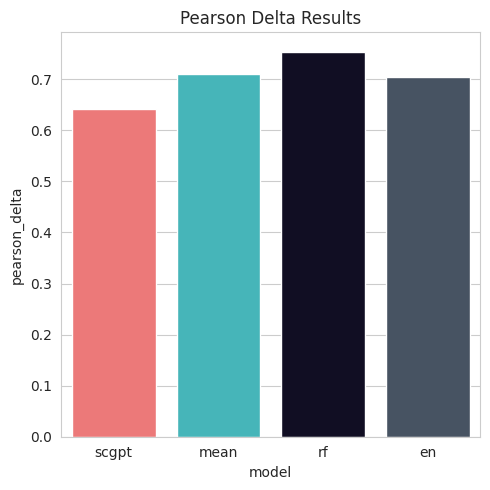

In [ ]:
df = pd.DataFrame.from_dict(dict(
    scgpt=adamson_scgpt,
    mean=adamson_res_mean,
    rf=adamson_res_rf,
    en=adamson_res_en,
), orient='index')
df = df.reset_index().rename(columns={"index": "model"})

plot_results(df)

<Axes: xlabel='model', ylabel='pearson_delta'>

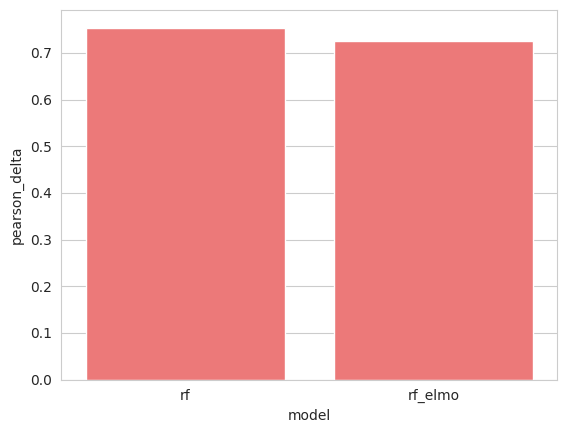

In [22]:
df = pd.DataFrame.from_dict(dict(
    rf=adamson_res_rf,
    rf_elmo=adamson_res_rf_elmo,
), orient='index')
df = df.reset_index().rename(columns={"index": "model"})

sns.barplot(x='model', y='pearson_delta', data=df)

In [ ]:
df = pd.DataFrame.from_dict(dict(
    scgpt=adamson_scgpt,
    mean=adamson_res_mean,
    rf=adamson_res_rf,
    en=adamson_res_en,
), orient='index')
df = df.reset_index().rename(columns={"index": "model"})

plot_results(df)

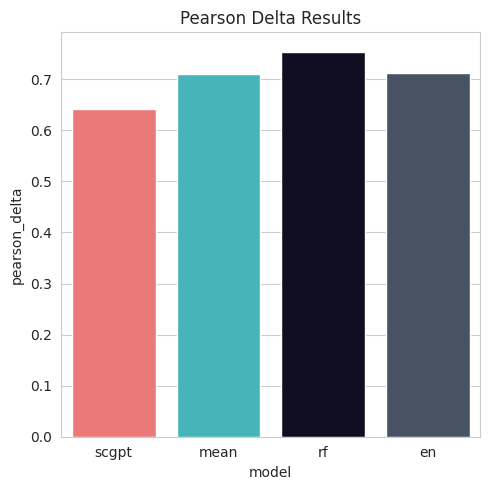

In [27]:
df = pd.DataFrame.from_dict(dict(
    scgpt=adamson_scgpt,
    mean=adamson_res_mean,
    rf=adamson_res_rf,
    en=adamson_res_en,
), orient='index')
df = df.reset_index().rename(columns={"index": "model"})

plot_results(df)

In [ ]:
adamson_res_rf

In [15]:
df = pd.DataFrame.from_dict(dict(
    scgpt=norman_scpt,
    mean=norman_res_mean,
    rf=norman_res_rf,
    en=norman_res_en,
), orient='index')
df = df.reset_index().rename(columns={"index": "model"})

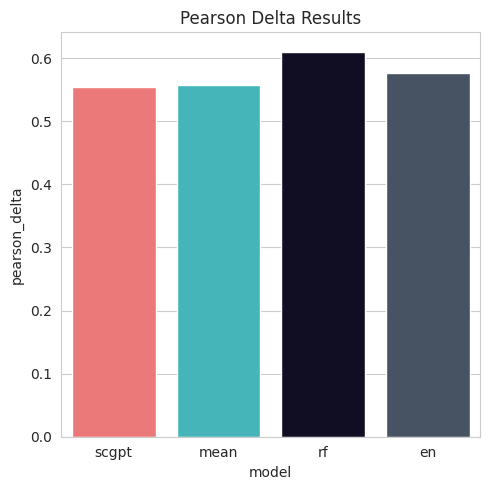

In [16]:
plot_results(df)

In [30]:
df = pd.DataFrame.from_dict(dict(
    scgpt=replogle_scgpt,
    mean=replogle_res_mean,
    rf=replogle_res_rf,
    en=replogle_res_en,
), orient='index')
df = df.reset_index().rename(columns={"index": "model"})


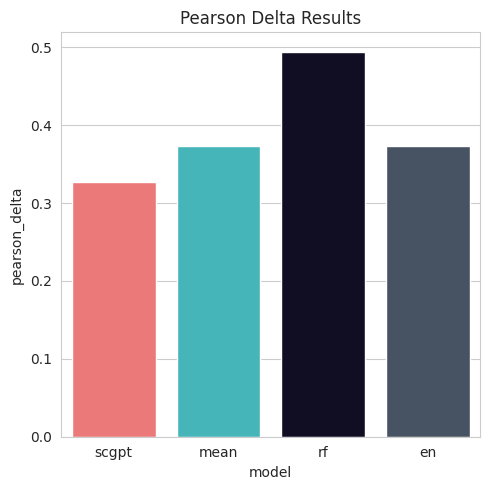

In [31]:
plot_results(df)

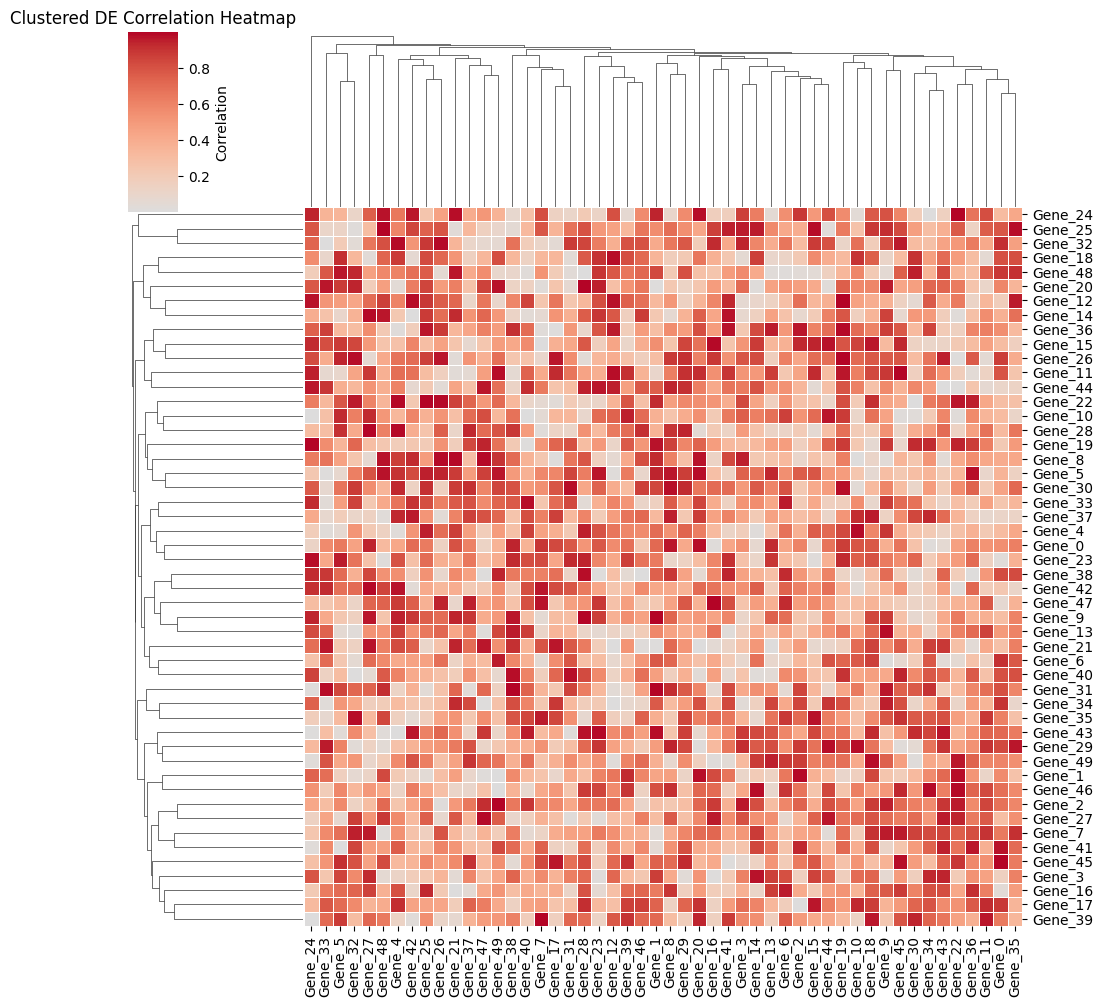

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Example: Generate synthetic correlation data
np.random.seed(0)
data = np.random.rand(50, 50)  # Replace with your actual correlation matrix
df = pd.DataFrame(data, columns=[f"Gene_{i}" for i in range(50)], index=[f"Gene_{i}" for i in range(50)])

# Clustered heatmap
g = sns.clustermap(df, cmap="coolwarm", center=0, linewidths=0.5, figsize=(10, 10),
                   xticklabels=True, yticklabels=True, cbar_kws={'label': 'Correlation'})

plt.title("Clustered DE Correlation Heatmap")
plt.show()
